In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

# Semantic Segmentation Model for Buildings and Solar Panels

In [2]:
import pickle
from pathlib import Path
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [3]:
segmentation_cmap = colors.ListedColormap(
    [(1,1,1), (0.5, 0.5, 0.5), (0,0,1), (1,0,0), (1,1,0)]
)

## Training a Semantic Segmentation Model
To train our semantic segmentation model, we use a script that is located in the `scripts/semantic_segmentation` directory. This script takes several arguments, including the version of the experiment, the output directory, the file that specifies how the dataset is split into training, validation, and test sets, and the directories that contain the dataset chips and their corresponding masks.

Here is an example of how to run the training script:
```bash
cd scripts/semantic_segmentation
python train.py --exp-version example --output-dir ../../outputs/ --tile-split-file ../../config/examples/data_preprocessing/tiled_dataset_splits/tiled_dataset_splits_1.yml --chip-dir ../../data/processed/example_chipped_datasets/semantic_segmentation/images/ --mask-dir ../../data/processed/example_chipped_datasets/semantic_segmentation/masks/
```
The training script trains a model using the specified dataset and saves the model checkpoints in the output directory. The best checkpoint, as determined by the validation performance, is then used to generate predictions on the dataset chips. These predictions are also saved in the output directory.

Let's load some of these chip predictions and visualize them to see how the model predictions look:

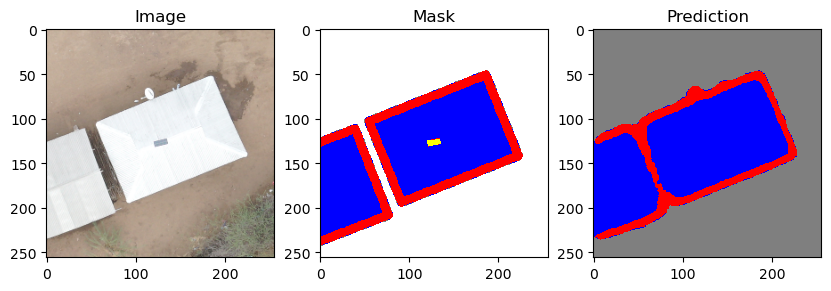

In [4]:
# Load chip predictions
chip_preds_f = Path('../outputs/semantic_segmentation/example-2024-01-19-01-06-30/epoch=19-step=80_chip_inference.pkl')
with chip_preds_f.open('rb') as f:
    chip_preds = pickle.load(f)

# Get the first item from the test chips
chip_path, chip_pred = list(chip_preds['test_chips'].items())[0]

# Load the chip image
chip_rel_path = chip_path.relative_to('../')
with rasterio.open(chip_rel_path) as ds:
    chip_img = ds.read()[0:3].transpose(1, 2, 0)

# Load the mask image
mask_path = Path(*[part if part != 'images' else 'masks' for part in chip_rel_path.parts])
with rasterio.open(mask_path) as ds:
    mask_img = ds.read().squeeze()

# Plot the image, mask, and prediction
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(chip_img)
ax[0].set_title('Image')
ax[1].imshow(mask_img, cmap=segmentation_cmap, vmin=0, vmax=4)
ax[1].set_title('Mask')
ax[2].imshow(chip_pred, cmap=segmentation_cmap, vmin=0, vmax=4)
ax[2].set_title('Prediction')
plt.show()

The image displayed is a color-coded visualization of the semantic segmentation output. Each color corresponds to a specific class, mirroring the label mapping used during model training: 'no data' (0) is white, 'background' (1) is grey, 'building' (2) is blue, 'building boundary' (3) is red, and 'solar panels' (4) is yellow. Note that 'no data' areas in the mask are largely due to the background being unlabeled. Despite this, the training dataset assigns these pixels to the 'background' class, enabling the model to learn to predict 'background' for similar areas. However, we see that this model has not yet learned to segment the solar panel class. Our models trained with the full dataset (with over 5 times as many pre-sampled chips) did learn the solar panel class.

## Running Semantic Segmentation Model Inference
To execute inference using a semantic segmentation model checkpoint on entire rasters (as opposed to pre-sampled chips), we use the inference script located in the `scripts/semantic_segmentation` directory. For example, we can use this to get semantic segmentation predictions on all of the collected aerial imagery. Fow now, let's run inference on just our mosiacked rasters:
```bash
cd scripts/semantic_segmentation
python inference.py --config ../../config/examples/semantic_segmentation/inference/inference_mosaics.yml -r $PROJECT_ROOT
```
This script operates by systematically sampling chips from the entire scene in a regular, grid-like pattern, and then generates predictions for each of these chips. These predictions are then compiled into a single, comprehensive output that covers the entire scene. The following visualization displays the model's predictions for the Kakuma_15 area:

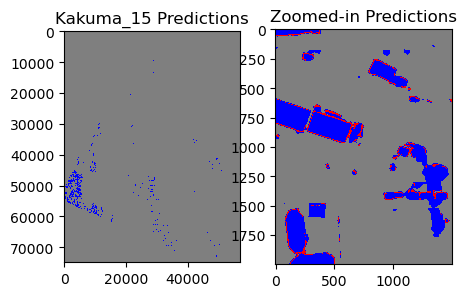

In [5]:
# Load scene predictions
scene_preds_f = '../outputs/semantic_segmentation/example-2024-01-19-01-06-30/inference/epoch=19-step=80_kakuma_15.tif'
with rasterio.open(scene_preds_f) as src:
    scene_preds = src.read().squeeze()

fig, ax = plt.subplots(1, 2, figsize=(5, 10))
# Plot the entire scene predictions
ax[0].imshow(scene_preds, cmap=segmentation_cmap, vmin=0, vmax=4)
ax[0].set_title('Kakuma_15 Predictions')
# Plot a zoomed in section of the predictions
ax[1].imshow(scene_preds[55000:57000, 5000:6500], cmap=segmentation_cmap, vmin=0, vmax=4)
ax[1].set_title('Zoomed-in Predictions')
plt.show()


To transform these raw pixel-wise predictions into object detections, the raster can be vectorized at pixels that correspond to the target class value. The `polygonize_predictions.py` script facilitates this process. For instance, to convert building predictions from the raster into polygon geometries, the following command is used:

```bash
python polygonize_predictions.py --raster-path ../../outputs/semantic_segmentation/example-2024-01-19-01-06-30/inference/epoch\=19-step\=80_kakuma_15.tif --vector-path ../../outputs/semantic_segmentation/example-2024-01-19-01-06-30/inference/epoch\=19-step\=80_kakuma_15_buildings.gpkg --raster-value 2
```

This vector file, containing the polygon geometries, can be imported into Geographic Information System (GIS) software such as QGIS. Once loaded, it can be overlaid on the aerial imagery for detailed examination.